# Models for Households

This section builds the foundation of a household energy system model to explore the household-level integration of sector coupling technologies such as heat pumps, batteries and electric vehicles and interactions with the electricity grid.

![network-model](_assets/households.png)

## Model Foundation

In [20]:
from demandlib import bdew
import datetime
import pandas as pd
import numpy as np
import pypsa

RESOLUTION = 2  # 3-hourly
SOLVER = "highs"  # or 'gurobi'

### Cost Assumptions

We take techno-economic assumptions from the [technology-data](https://github.com/PyPSA/technology-data) repository which collects assumptions on costs and efficiencies:

In [3]:
YEAR = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{YEAR}.csv"
costs = pd.read_csv(url, index_col=[0, 1])
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs = costs.value.unstack().fillna({"discount rate": 0.07, "lifetime": 20, "FOM": 0})

We calculate the capital costs (i.e. annualised investment costs, €/MW/a or €/MWh/a for storage), using the discount rate and lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

a = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (a + costs["FOM"] / 100) * costs["investment"]

In [5]:
url = "https://tubcloud.tu-berlin.de/s/QWWKYrgMbpHAXEX/download/ninja-weather-DE30-2013.csv"
temperature = pd.read_csv(url, index_col=0)
temperature.head(3)

,DE30
time,
2013-01-01 00:00:00,3.162
2013-01-01 01:00:00,3.041
2013-01-01 02:00:00,2.659


### Heat and Electricity Demand

Hourly demand and electricity demand time series are generated using the [demandlib](https://demandlib.readthedocs.io/en/latest/bdew.html#) tool, which uses standard load profiles. Let's assume an electricity demand of 3000 kWh per year and heat demand of 15,000 kWh per year.

In [6]:
HOLIDAYS = {
    datetime.date(2013, 1, 1): "New Year's Day",
    datetime.date(2013, 1, 6): "Epiphany",
    datetime.date(2013, 3, 29): "Good Friday",
    datetime.date(2013, 4, 1): "Easter Monday",
    datetime.date(2013, 5, 1): "Labour Day",
    datetime.date(2013, 5, 9): "Ascension Day",
    datetime.date(2013, 5, 20): "Whit Monday",
    datetime.date(2013, 5, 30): "Corpus Christi",
    datetime.date(2013, 10, 3): "Day of German Unity",
    datetime.date(2013, 10, 31): "Reformation Day",
    datetime.date(2013, 12, 25): "Christmas Day",
    datetime.date(2013, 12, 26): "St. Stephen's Day",
}

In [7]:
e_slp = bdew.ElecSlp(year=2013, holidays=HOLIDAYS)
elec = (
    e_slp.get_scaled_power_profiles({"h0": 3000}).resample("h").mean().squeeze(axis=1)
)
elec.head(3)

2013-01-01 00:00:00    0.234655
2013-01-01 01:00:00    0.169026
2013-01-01 02:00:00    0.135311
Freq: h, Name: h0, dtype: float64

In [8]:
index = pd.date_range(start="2013-01-01", periods=8760, freq="h")

heat = bdew.HeatBuilding(
    index,
    holidays=HOLIDAYS,
    temperature=temperature,
    shlp_type="EFH",
    building_class=11,
    wind_class=1,
    annual_heat_demand=15000,
    name="EFH",
    ww_incl=True,
).get_bdew_profile()
heat.head(3)

2013-01-01 00:00:00    1.537562
2013-01-01 01:00:00    1.584357
2013-01-01 02:00:00    1.624467
Freq: h, Name: temperature_geo, dtype: float64

### Wind and Solar Time Series

Capacity factor time series for wind and solar we take again from [model.energy](https://model.energy) for a location around Berlin.

In [9]:
url = "https://model.energy/data/time-series-77710a0d1997bc060695fbe92f4c55c3.csv"
ts = pd.read_csv(url, index_col=0, parse_dates=True)
ts.head(3)

,solar,onwind
time,,
2013-01-01 00:00:00,0.0,0.792
2013-01-01 01:00:00,0.0,0.758
2013-01-01 02:00:00,0.0,0.735


### Electricity Price Time Series

Hourly wholesale electricity price time series for the German bidding zone we take from the [OPSD Platform](https://data.open-power-system-data.org/time_series/2019-06-05). We will not use these time series directly, but add 30 €ct/kWh of static charges and levies to approximate household electricity tariffs with some dynamic component.

In [10]:
url = "https://tubcloud.tu-berlin.de/s/osPQXnBYk4RrNSR/download/price-time-series-DE-2013.csv"
prices = pd.read_csv(url)["DE_price_day_ahead"] / 1000 # €/kWh
prices.index = index
prices.head(3)

2013-01-01 00:00:00    0.01403
2013-01-01 01:00:00    0.01106
2013-01-01 02:00:00    0.00850
Freq: h, Name: DE_price_day_ahead, dtype: float64

### Model Setup

Let's start by initialising the network with buses for electricity, heat and an electric vehicle and hourly snapshots.

In [11]:
n = pypsa.Network()

buses_i = ["electricity", "heat", "EV"]
n.add("Bus", buses_i, carrier=buses_i, unit="kW")

n.set_snapshots(ts.index)

CARRIERS = {
    "solar": "gold",
    "battery storage 1h": "magenta",
    "battery storage 3h": "magenta",
    "battery storage 6h": "magenta",
    "electricity demand": "grey",
    "heat demand": "indianred",
    "gas boiler": "brown",
    "ground heat pump": "forestgreen",
    "air heat pump": "lightgreen",
    "resistive heater": "orange",
    "hot water storage": "red",
    "from grid": "steelblue",
    "to grid": "steelblue",
    "electricity": "grey",
    "heat": "indianred",
    "EV": "cadetblue",
    "EV demand": "cadetblue",
    "EV charger": "limegreen",
    "V2G": "limegreen",
    "EV battery": "teal",
}

n.add(
    "Carrier",
    CARRIERS.keys(),
    color=CARRIERS.values(),
);

Now, we add the electricity demand, the option to build up to 10 kW of rooftop PV, the option to import from the grid at 30 €ct/kWh plus the dynamic wholesale electricity price, the option to export to the grid for a feed-in tariff of 4 €ct/kWh. Batteries can be built with an energy-to-power ratio of 1h, 3h and 6h. 

In [12]:
n.add(
    "Load",
    "electricity demand",
    bus="electricity",
    p_set=elec, # kW
    carrier="electricity demand",
)


n.add(
    "Generator",
    "solar",
    bus="electricity",
    p_nom_extendable=True,
    capital_cost=costs.at["solar-rooftop", "capital_cost"] / 1000,
    p_max_pu=ts.solar,
    p_nom_max=10, # kW
    carrier="solar",
)

n.add(
    "Generator",
    "from grid",
    bus="electricity",
    marginal_cost=prices + 0.3, # €/kWh
    p_nom=20, # kW
    carrier="from grid",
)

n.add(
    "Generator",
    "to grid",
    bus="electricity",
    carrier="to grid",
    p_nom=20, # kW
    marginal_cost=0.04, # €/kWh feed-in tariff
    p_min_pu=-1,
    p_max_pu=0,
)


for max_hours in [1, 3, 6]:
    n.add(
        "StorageUnit",
        f"battery storage {max_hours}h",
        bus="electricity",
        carrier=f"battery storage {max_hours}h",
        max_hours=max_hours,
        capital_cost=costs.at["battery inverter", "capital_cost"] / 1000
        + max_hours * costs.at["battery storage", "capital_cost"] / 1000,
        efficiency_store=costs.at["battery inverter", "efficiency"],
        efficiency_dispatch=costs.at["battery inverter", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )


Now, we add the heat demand as well as several technologies to supply heat. This includes a fossil gas boiler option at a cost of 9 €ct/kWh. The gas boiler must follow the heat load profile and cannot be mixed with the heat pump (no hybrid setup allowed). We have two heat pump options: a ground-sourced heat pump with a constant higher coefficient of performance (but higher cost) and an air-sourced heat pump with time-varying coefficient of performance depending on ambient weather conditions (but lower cost). Additionally, there is a cheap resistive heater option and the option to build a small hot water storage tank for buffering heat supply.

In [13]:

n.add("Load", "heat demand", bus="heat", p_set=heat, carrier="heat demand")


n.add(
    "Generator",
    "gas boiler",
    bus="heat",
    marginal_cost=0.09, # €/kWh
    p_nom_extendable=True,
    capital_cost=costs.at["decentral gas boiler", "capital_cost"] / 1000, # €/kW/a
    carrier='gas boiler',
    p_min_pu=heat / heat.max(), # load-following
)

n.add(
    "Link",
    "ground heat pump",
    bus0="electricity",
    bus1="heat",
    p_nom_extendable=True,
    capital_cost=costs.at["decentral ground-sourced heat pump", "capital_cost"] / 1000,
    efficiency=costs.at["decentral ground-sourced heat pump", "efficiency"],
    carrier="ground heat pump",
)

def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 1.3 * (6.81 - 0.121 * delta_t + 0.000630 * delta_t**2)

n.add(
    "Link",
    "air heat pump",
    bus0="electricity",
    bus1="heat",
    p_nom_extendable=True,
    capital_cost=costs.at["decentral air-sourced heat pump", "capital_cost"] / 1000,
    efficiency=cop(temperature.squeeze()).values,
    carrier="air heat pump",
)

n.add(
    "Link",
    "resitive heater",
    bus0="electricity",
    bus1="heat",
    p_nom_extendable=True,
    capital_cost=costs.at["decentral resistive heater", "capital_cost"] / 1000,
    efficiency=costs.at["decentral resistive heater", "efficiency"],
    carrier="resistive heater",
)

n.add(
    "Store",
    "hot water storage",
    bus="heat",
    carrier="hot water storage",
    capital_cost=costs.at["decentral water tank storage", "capital_cost"] / 1000,
    standing_loss=costs.at["decentral water tank storage", "standing losses"] / 100,
    e_nom_extendable=True,
);

### Electric Vehicles

Here, we add an electric vehicle (EV) as previously shown in the sector-coupling tutorial, just narrowed down to a single vehicle. The vehicle has an availability profile for when it is connected to the grid, and a requirement profile for the minimum state of charge it should have at certain times of the day (e.g. 75% at 6 AM). The charging power is assumed to be 11 kW and the battery size is assumed to be 50 kWh.

In [ ]:
number_cars = 40e6  #  number of EV cars
bev_charger_rate = 11  # 3-phase EV charger with 11 kW
bev_energy = 50  # EV battery size in kWh

url = "https://tubcloud.tu-berlin.de/s/9r5bMSbzzQiqG7H/download/electric-vehicle-profile-example.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze().div(number_cars)
p_set = p_set.resample("1h").mean().interpolate()
p_set.index = p_set.index.shift(-(2 * 365), freq="D")
p_set = p_set.reindex(n.snapshots).ffill()


For the availability time series, with a single vehicle, we now have to work with discrete values. We can achieve this by using a binomial distribution to simulate the availability of the vehicle over time, taking into account the hours of the day and the day of the week and implement some additional hard constraints.

In [ ]:
url = "https://tubcloud.tu-berlin.de/s/E3PBWPfYaWwCq7a/download/electric-vehicle-availability-example.csv"
available = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()
available = available.resample("1h").mean().interpolate()
available.index = available.index.shift(-(2 * 365), freq="D")
available = available.reindex(n.snapshots).ffill()

rng = np.random.default_rng(42)  # seed for reproducibility
available = pd.Series(rng.binomial(1, available), index=available.index)
hours = available.index.hour
weekday = available.index.weekday
available[(hours >= 23) | (hours < 5)] = 1   # always at home 23–05
available[(hours >= 10) & (hours < 15) & (weekday < 5)] = 0  # always away 10–15
available.loc["2013-01-01":"2013-01-07"].plot()

Then, we can add the PyPSA components just as before:

In [ ]:
n.add("Load", "EV demand", bus="EV", carrier="EV demand", p_set=p_set)

n.add(
    "Link",
    "EV charger",
    bus0="electricity",
    bus1="EV",
    p_nom=bev_charger_rate,
    carrier="EV charger",
    p_max_pu=available,
    efficiency=0.9,
)

n.add(
    "Link",
    "V2G",
    bus0="EV",
    bus1="electricity",
    p_nom=bev_charger_rate,
    carrier="V2G",
    p_max_pu=available,
    efficiency=0.9,
)

requirement = pd.Series(0., index=n.snapshots)
requirement.where(requirement.index.hour != 6, 0.75, inplace=True)

n.add(
    "Store",
    "EV battery",
    bus="EV",
    carrier="EV battery",
    e_cyclic=True,  # state of charge at beginning = state of charge at the end
    e_nom=bev_energy,
    e_min_pu=requirement,
);

### Temporal Clustering

To save some computation time, we only sample every third snapshot, which corresponds to a temporal resolution of 3 hours. Note that the snapshot weightings (the duration each time step represents) have to be adjusted accordingly.

In [15]:
n.set_snapshots(n.snapshots[::RESOLUTION])
n.snapshot_weightings.loc[:, :] = RESOLUTION


<Axes: xlabel='snapshot'>

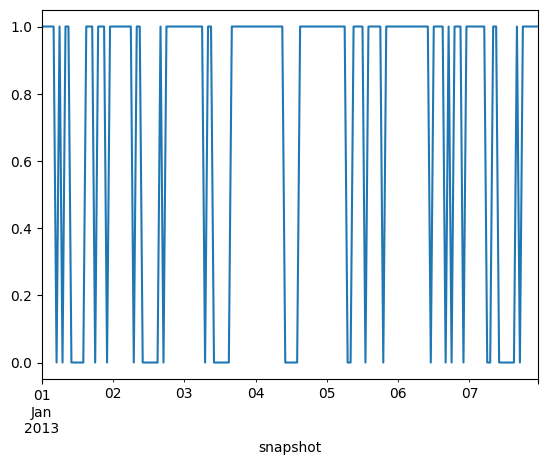

## Exploration

We could now already run the optimisation and look at a first set of results.

In [16]:
# n.optimize(
#     solver_name=SOLVER,
#     log_to_console=False,
# )

But the exploration is left to you! Here are some ideas for sensitivities to explore and metrics to look at:

**Metrics:**

- Total annual energy cost for the household and breakdown by technology (billion €/a and % of total cost). This can be built from `n.statistics.opex(groupby=["bus", "carrier"])` and `n.statistics.capex(groupby=["bus", "carrier"])`.
- Energy balances of the household. This can be accessed from `n.statistics.energy_balance(groupby=["bus", "carrier"], bus_carrier='electricity')` and plotted intereactively with `n.statistics.energy_balance.iplot.area(bus_carrier="electricity")`.

**Sensitivities:**

- Disable ground water heat pumps.
- Make battery storage cheaper.
- Do not allow exports to the grid.
- Reduce feed-in tariff to zero, but still allow exports to the grid (for zero compensation).
- Make the household autarkic and disconnect it from the grid (both import and export).
- Reduce the gas price.
- Reduce the heat demand to mimic building renovation measure for higher energy efficiency.
- Remove the battery electric vehicle.
- Allow hybrid heat supply with heat pumps and a gas boiler as a backup by removing the `p_min_pu` attribute for the gas boiler.


**Feel free to explore other ideas as well!**